# IBM Coursera Advanced Data Science Capstone - Part 1

# Building a Sentiment Classifier

Sentiment analysis is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows businesses to identify customer sentiment toward products, brands or services in online conversations and feedback.

In this notebook, I will demonstrate how a sentiment classifier be built via Keras API's IMDB Dataset. This time I will try to build the sentiment classifier with Autoencoder(Encoder and Decoder) rather than RNN-LSTM due to too many researches had been done for the latter. Besides, I will train my sentiment classifier with Support Vector Machine and GridSearchCV methods.

## Goals

In this project, I expect to:

- Learn Sentiment Classifiers
- Understand the application of Autoencoders such as Restricted Boltzmann Machines and Deep Belief Networks
- Build a simple model for a real usecase: Sentiment Classifier of identifying both positive and negative reviews
- Understand how to validate the results

## Steps

- Import IMDB Dataset via Keras API by loading the dataset but only keep the top n words, zero the rest
- Formally define what is a sensible algorithm to achieve our goal: concisely, we want to build a statistical model of user   preferences such that we can use it to predict positive or negative sentiment in a statement and word.
- We will learn several approaches to implement the algorithms based on our formal definition on hand. We would show how to   overcome the difficulties to implement an algorithm which have large batch_size and dimensions.
- We will emphasize on how to validate the results we had obtained and even how to select good parameters to train on our     models.

# 1.0 Data

**Data Quality Assessment**

One of the most significant parts when deploying a Machine Learning algorithm would be understanding the data. I use the IMDB dataset linked with Keras API. IMDB is one of the most famous movie rating websites such as Rotten Tomato and Metacritic, or Fandango. 

## 1.1 Data Schema

Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. 

**Reading Materials**

- Semisupervised Autoencoder for Sentiment Analysis
Shuangfei Zhai, Zhongfei (Mark) Zhang
- Denoising Autoencoder with Finetuning (DAE+) 
Vincent et al. 2008.
- Semi-supervised recursive autoencoders for predicting sentiment distributions
Socher, R.; Pennington, J.; Huang, E. H.; Ng, A. Y.; and Manning, C. D. 2011.
- Dropout training as adaptive regularization
Wager, S.; Wang, S. I.; and Liang, P. 2013.

Instead of training all 25000 reviews for both training and test datasets in **Part 1**, we just do a smaller pilot test which we just keep training with 50 reviews in a batch. The larger the training set in batch size, the higher the accuracy and the lower the cost. However, our model proposed is quite sophisticated in number of layers and hence need to train longer than other traditional deep neural networks. **Besides, training with GridSearch Method with the controlled dataset already needs to consume up to more than 3 hours**. As concerning about its validaity of the accuracy of smaller batch size, we also compare our training set with **Support Vector Machine(SVM)** and even **GridSearch methods(parallelizing of hyperparameters tunings)**. If the accuracy and other metrics of our proposed Autoencoders method is close or better than SVM and even GridSearch methods, this means the proposed method is quite fine as SVM method can normally train quite well with IMDB Dataset with greater number of words, e.g. 5000 words. We will train more dataset in Part 2 of the project due to part 1 is mainly for comparison within different Machine and Deep Learning approaches, namely **LSTM-Autoencoder-FNN, SVM Classifier and GridSearchCV. FNN stands for Forward Neural Networks**.

## 1.2 Data Exploration: Simple Descriptive Statistics
We should firstly understand the data characteristics in order to choose or design a suitable algorithm for our own purposes. In the beginning, we are required to import the necessary packages to work with regular expression, algorithms, tensors, Deep Learning networks, Pipelines, Data Preprocessing, Feature Engineering and other more for our designated programming environment. 

## 1.3 Extract-Transform-Load (ETL)

We start by importing the required dependencies to preprocess our data and build our model.

This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

**get_word_index function**

tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

Retrieves a dict mapping words to their index in the IMDB dataset.

**Arguments**

path: where to cache the data (relative to ~/.keras/dataset).

**Returns**

The word index dictionary. Keys are word strings, values are their index.

In [1]:
# Importing libralies and downloading datasets
import numpy
from keras.datasets import imdb
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Input, LSTM, RepeatVector, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [2]:
# load the IMDB dataset but only keep the top n words, zero the rest
top_words = 50
# Train test split
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

### Q1. What is the dimensions and shape for both train and test sets?

Ans: (25000,)

In [3]:
# Check the dimensions and shape for both train and test set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


## 1.3 Data Visualization

Due to this is a NLP projects, therefore no charts and correlation heatmap would be generated. However, we can show the value distribution of the integers for our training set varies from 0 to 50.

In [4]:
# truncate and pad input sequences
max_review_length = 50
# X_train = X_train[:1000]
# y_train = y_train[:1000]
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# check and print out our training sets
print(X_train)
print(y_train)

[[ 2  2 26 ... 19  2 32]
 [ 2  5  2 ... 16  2  2]
 [ 2 28  2 ...  7  2  2]
 ...
 [ 4  2  2 ...  4  2  2]
 [13 18 31 ... 12  9 23]
 [ 2  8  2 ...  2  2  9]]
[1 0 0 ... 0 1 0]


## 1.4 Feature Engineering and Data Preprocessing

We normalize our data which varied from 1 to 50 integer into [0:1]. We even performed pad sequence for encoder_input and encoder_input_test on the cell above. So for the value > 0.5, we would categorize the sentiment into positive and otherwise would be negative.

In [5]:
encoder_input = numpy.zeros((len(X_train), max_review_length, top_words))
for i, sentence in enumerate(X_train):
    for j, word in enumerate(sentence):
        encoder_input[i, j, word] = 1

In [6]:
encoder_input_test = numpy.zeros((len(X_test), max_review_length, top_words))
for i, sentence in enumerate(X_test):
    for j, word in enumerate(sentence):
        encoder_input_test[i, j, word] = 1

### Q2. Why we need to have keeping our dimensions uniformly throughout autoencoders layers?

That is because we need to make sure the dimension of vector can be reshaped well once go through Sequential model of training.

# 2.0 Build a statistical model for Sentiment Analysis Classification

## 2.1 Introduction to Sentiment Analysis Classifier

Sentiment analysis uses various Natural Language Processing (NLP) methods and algorithms, which we’ll go over in more detail in this section.

The main types of algorithms used include:

**Rule-based systems** that perform sentiment analysis based on a set of manually crafted rules.

**Automatic systems** that rely on machine learning techniques to learn from data.

**Hybrid systems**that combine both rule-based and automatic approaches.

## 2.2 Rule-based Approaches

Usually, a rule-based system uses a set of human-crafted rules to help identify subjectivity, polarity, or the subject of an opinion.

These rules may include various techniques developed in computational linguistics, such as:

Stemming, tokenization, part-of-speech tagging and parsing.
Lexicons (i.e. lists of words and expressions).
Here’s a basic example of how a rule-based system works:

Defines two lists of polarized words (e.g. negative words such as bad, worst, ugly, etc and positive words such as good, best, beautiful, etc).
Counts the number of positive and negative words that appear in a given text.
If the number of positive word appearances is greater than the number of negative word appearances, the system returns a positive sentiment, and vice versa. If the numbers are even, the system will return a neutral sentiment.
Rule-based systems are very naive since they don't take into account how words are combined in a sequence. Of course, more advanced processing techniques can be used, and new rules added to support new expressions and vocabulary. However, adding new rules may affect previous results, and the whole system can get very complex. Since rule-based systems often require fine-tuning and maintenance, they’ll also need regular investments.

## 2.3 Automatic Approaches

Automatic methods, contrary to rule-based systems, don't rely on manually crafted rules, but on machine learning techniques. A sentiment analysis task is usually modeled as a classification problem, whereby a classifier is fed a text and returns a category, e.g. positive, negative, or neutral.

**The Training and Prediction Processes**

In the training process (a), our model learns to associate a particular input (i.e. a text) to the corresponding output (tag) based on the test samples used for training. The feature extractor transfers the text input into a feature vector. Pairs of feature vectors and tags (e.g. positive, negative, or neutral) are fed into the machine learning algorithm to generate a model.

In the prediction process (b), the feature extractor is used to transform unseen text inputs into feature vectors. These feature vectors are then fed into the model, which generates predicted tags (again, positive, negative, or neutral).

**Feature Extraction from Text**

The first step in a machine learning text classifier is to transform the text extraction or text vectorization, and the classical approach has been bag-of-words or bag-of-ngrams with their frequency.

More recently, new feature extraction techniques have been applied based on word embeddings (also known as word vectors). This kind of representations makes it possible for words with similar meaning to have a similar representation, which can improve the performance of classifiers.

**Classification Algorithms**

The classification step usually involves a statistical model like Naïve Bayes, Logistic Regression, Support Vector Machines, or Neural Networks:

Naïve Bayes: a family of probabilistic algorithms that uses Bayes’s Theorem to predict the category of a text.

Linear Regression: a very well-known algorithm in statistics used to predict some value (Y) given a set of features (X).

**Support Vector Machines: a non-probabilistic model which uses a representation of text examples as points in a multidimensional space. Examples of different categories (sentiments) are mapped to distinct regions within that space. Then, new texts are assigned a category based on similarities with existing texts and the regions they’re mapped to.**

**Deep Learning: a diverse set of algorithms that attempt to mimic the human brain, by employing artificial neural networks to process data.**

## 2.4 Hybrid Approaches

Hybrid systems combine the desirable elements of rule-based and automatic techniques into one system. One huge benefit of these systems is that results are often more accurate.

In [7]:
# Define Encoder and Decoder layers of autoencoders 
latent_dim=top_words
inputs = Input(shape=(max_review_length, top_words))
print(inputs.shape)
encoded = LSTM(latent_dim,return_sequences=False,dropout=0.1)(inputs)
print(encoded.shape)
encoded = Dense(latent_dim,activation='sigmoid')(encoded)
print(encoded.shape)
decoded = RepeatVector(max_review_length)(encoded)
print(decoded.shape)
decoded = LSTM(latent_dim, return_sequences=True)(decoded)
print(decoded.shape)
decoded = Activation('softmax')(decoded)
print(decoded.shape)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

(None, 50, 50)
(None, 50)
(None, 50)
(None, 50, 50)
(None, 50, 50)
(None, 50, 50)


In [8]:
sequence_autoencoder.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

# 3.0 Usecase: Sentiment Analysis Classifier

In this use case, we use the IMDB Datasets in the previous sessions to build a Deep Learning / statistical model to classify both positive and negative reviews.

## 3.1 Requirements

We require to choose a Sentiment Analysis Classifier that is suitable for this implicit feedback data due to the properties of data. It means that the algorithm should learn without access to other labelled data. Therefore, an algorithm of type Autoencoders is the best choice. In this project, we will use a specialized type of Autoencoder which is LSTM-Autoencoder-FNN. 

LSTM-Autoencoder-FNN is a deep learning architecture consist of one Autoencoder (Encoder and Decoder) and one Neural Networks (Forward Neural Networks). The Autoencoder is trained with LSTM layer. Normally, Autoencoder is just like Convolutional Neural Networks(CNN) and Generative Adversarial Networks(GANs), it is mostly trained for image data but it doesn't mean its applications are not widely cited for non-image data such as word files and sequence data.

Besides, we even use Support Vector Machine in Machine Learning method. SVM is defined as a non-probabilistic model which uses a representation of text examples as points in a multidimensional space. Examples of different categories (sentiments) are mapped to distinct regions within that space. Then, new texts are assigned a category based on similarities with existing texts and the regions they’re mapped to.

We need to have an environment that can run this deep layers quite conveniently, therefore Keras libraries would be my primary choice of doing so due to faster and more convenient deployment of the models.

## 3.2 Data Preprocessing

This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

## 3.3 Training our LSTM-Autoencoder-FNN Model

We split our Deep Learning model to train in two stages. First one would be Autoencoder which consists of both encoder and decoder shown as previous cells. The second one would be Neural Networks with Bernoulli's dropout of 0.5 in Dense layers.

In [9]:
sequence_autoencoder.fit(encoder_input,encoder_input,batch_size = 64,epochs = 10, validation_data=(encoder_input_test, encoder_input_test)) # validation_split=0.3)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 60s 2ms/step - loss: 2.9024 - accuracy: 0.5659 - val_loss: 2.8666 - val_accuracy: 0.5710
Epoch 2/10
25000/25000 [==============================] - 55s 2ms/step - loss: 2.8524 - accuracy: 0.5764 - val_loss: 2.8526 - val_accuracy: 0.5710
Epoch 3/10
25000/25000 [==============================] - 54s 2ms/step - loss: 2.8406 - accuracy: 0.5764 - val_loss: 2.8455 - val_accuracy: 0.5710
Epoch 4/10
25000/25000 [==============================] - 58s 2ms/step - loss: 2.8359 - accuracy: 0.5728 - val_loss: 2.8408 - val_accuracy: 0.5650
Epoch 5/10
25000/25000 [==============================] - 64s 3ms/step - loss: 2.8331 - accuracy: 0.5697 - val_loss: 2.8340 - val_accuracy: 0.5645
Epoch 6/10
25000/25000 [==============================] - 54s 2ms/step - loss: 2.8277 - accuracy: 0.5719 - val_loss: 2.8288 - val_accuracy: 0.5663
Epoch 7/10
25000/25000 [==============================] - 51s 2ms/st

### Q3. What is the output and dimension of encoded_train?

In [10]:
encoded_train = encoder.predict(encoder_input)
print(encoded_train)
embedded_train = numpy.reshape(encoded_train, (len(encoder_input),top_words))
print(encoded_train.shape)

[[0.485163   0.7228535  0.5553642  ... 0.5678121  0.38712692 0.63023484]
 [0.3210926  0.3122807  0.655512   ... 0.6773187  0.4901366  0.26814336]
 [0.24665353 0.44667742 0.4651661  ... 0.44640094 0.7690921  0.3146783 ]
 ...
 [0.7719679  0.34432426 0.87831974 ... 0.85434926 0.7260455  0.22256741]
 [0.09963772 0.69851774 0.19799438 ... 0.18468368 0.3263508  0.76659447]
 [0.6475265  0.2612226  0.10930958 ... 0.5399675  0.22684893 0.4049739 ]]
(25000, 50)


### Q4. What is the output and dimension of encoded_test?

In [11]:
encoded_test = encoder.predict(encoder_input_test)
print(encoded_test)
embedded_test = numpy.reshape(encoded_test, (len(encoder_input),top_words))
print(encoded_test.shape)

[[0.5124394  0.65343624 0.11755663 ... 0.1106618  0.23729405 0.90112686]
 [0.5778312  0.5386807  0.22924611 ... 0.5928309  0.42437875 0.4527956 ]
 [0.44707033 0.30736458 0.83385533 ... 0.5144815  0.7585947  0.36873645]
 ...
 [0.5388301  0.7639849  0.5443272  ... 0.57787627 0.502679   0.6291964 ]
 [0.26832724 0.44146293 0.24069673 ... 0.49085817 0.24101225 0.4587442 ]
 [0.6811333  0.6026007  0.70211196 ... 0.76920325 0.87349033 0.25256032]]
(25000, 50)


### Q5. What is the number of total params and trainable params?

In [22]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(top_words,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='hard_sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
b = model.fit(embedded_train, y_train, validation_data=(embedded_test, y_test), epochs=20, batch_size=64)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                3264      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 7,489
Trainable params: 7,489
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 2s 60

## 3.4 Evaluation of Data

### Q6. What is the accuracy for LSTM-Autoencoder-FNN?

In [23]:
scores = model.evaluate(embedded_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 56.53%


**The accuracy score of our LSTM-Autoencoder-FNN combinations can even perform quite well in small batch of training data. Although it is quite expected to have greater loss of information compared to larger dataset (>5000 words).**

In [24]:
hist=b.history
print(hist)

{'val_loss': [0.6870786929893493, 0.6843540974044799, 0.6835818723487854, 0.6838204356575012, 0.6841296496582031, 0.6837077370071412, 0.6832175262451172, 0.682130323047638, 0.6832878700065613, 0.6827063982963562, 0.6824732786750793, 0.6815298572158813, 0.6818699464225769, 0.6812024221992493, 0.683202809009552, 0.6825916231918335, 0.6828731410789489, 0.6814879717636109, 0.6822320027160644, 0.6815837493515015], 'val_accuracy': [0.5448399782180786, 0.5548800230026245, 0.5580400228500366, 0.5601999759674072, 0.5573199987411499, 0.5606799721717834, 0.5600399971008301, 0.5606799721717834, 0.5628799796104431, 0.5588799715042114, 0.5608800053596497, 0.5631200075149536, 0.5638399720191956, 0.5649200081825256, 0.561519980430603, 0.563040018081665, 0.5629600286483765, 0.5645999908447266, 0.5646799802780151, 0.5653200149536133], 'loss': [0.6928127138900757, 0.6873754368209839, 0.6863049569320678, 0.6847589468383789, 0.6854635939788818, 0.6842674683761597, 0.6844485563278199, 0.6840836956405639, 0.

## 3.5 Exploratory Data Analysis (EDA)

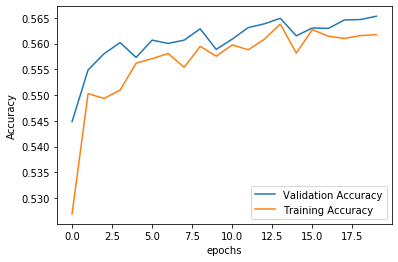

In [25]:
import matplotlib.pyplot as plt
plt.plot(hist["val_accuracy"],label="Validation Accuracy")
plt.plot(hist["accuracy"],label="Training Accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

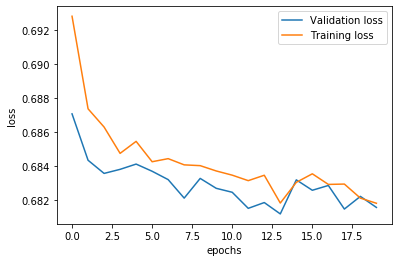

In [26]:
plt.plot(hist["val_loss"],label="Validation loss")
plt.plot(hist["loss"],label="Training loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [27]:
model.evaluate(X_test,y_test)[1]

25000/25000 [==============================] - 1s 26us/step


0.4947200119495392

In [28]:
model.evaluate(X_train,y_train)[1]

25000/25000 [==============================] - 1s 26us/step


0.501479983329773

In [29]:
output=model.predict(X_test)
print(output)

[[0.        ]
 [0.98334825]
 [1.        ]
 ...
 [1.        ]
 [1.        ]
 [1.        ]]


In [30]:
for i in output:
    if i>0.5:
        print("Positive Review")
    else:
        print("Negative Review")

Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive

Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive

Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive

Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative

Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive

Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive

Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive

Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive

Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive

Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive

Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive

Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative

Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive

Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive

Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive

Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive

Negative Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Negative Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Negative Review
Negative Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Negative Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Positive Review
Positive Review
Positive Review
Negative Review
Positive Review
Negative Review
Positive

In [31]:
print(y_test)

[0 1 1 ... 0 0 0]


## 3.7 Train a Model with Machine Learning method

Now its time to train a **Support Vector Machine Classifier**. 

**Call the SVC() model from sklearn and fit the model to the training data.**

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
svc_model = SVC()

In [34]:
svc_model.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## 3.8 Model Evaluation

**Now get predictions from the model and create a confusion matrix and a classification report.**

In [35]:
predictions = svc_model.predict(X_test)

In [36]:
print(confusion_matrix(y_test,predictions))

[[5992 6508]
 [5530 6970]]


### Q7. What is the F1-score and Accuracy for SVM Classifier?

In [37]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.52      0.48      0.50     12500
           1       0.52      0.56      0.54     12500

    accuracy                           0.52     25000
   macro avg       0.52      0.52      0.52     25000
weighted avg       0.52      0.52      0.52     25000



**Support Vector Machine recorded a 52% of average accuracy score with small training batch of data.**

## 3.9 GridSearch (Hyperparameter tunings)

**Import GridSearchCV from Scikit-Learn.**

In [38]:
from sklearn.model_selection import GridSearchCV

**Create a dictionary called param_grid and fill out some parameters for C and gamma.**

In [39]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

** Create a GridSearchCV object and fit it to the training data.**

In [40]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... C=0.1, gamma=1, total= 1.5min
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV] ................................... C=0.1, gamma=1, total= 1.5min
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 1.4min
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 1.5min
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 1.5min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 1.6min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 1.5min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 1.5min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .

[CV] ................................ C=10, gamma=0.001, total= 2.7min
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total= 3.3min
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total= 3.0min
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total= 4.0min
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total= 3.7min
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total= 3.6min
[CV] C=100, gamma=0.1 ................................................
[CV] ................................. C=100, gamma=0.1, total= 3.5min
[CV] C=100, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 204.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

**The best hyperparameters for GridSearchCV would be c=1.0 and also gamma='scale'.**

In [41]:
grid_predictions = grid.predict(X_test)

## 3.10 Model Evaluation

**Now get predictions from the model and create a confusion matrix and a classification report.**

In [42]:
print(confusion_matrix(y_test, grid_predictions))

[[9004 3496]
 [8222 4278]]


### Q8. What is the F1-score and Accuracy for GridSearchCV?

In [43]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.52      0.72      0.61     12500
           1       0.55      0.34      0.42     12500

    accuracy                           0.53     25000
   macro avg       0.54      0.53      0.51     25000
weighted avg       0.54      0.53      0.51     25000



**GridSearchCV Method showed an average accuracy score of 53% of accuracy score with small training batch of data.**

### Q9. Which methods/approaches performed the best among the rest and why?

# 4.0 Conclusion / Final Result

**Given same training and test dataset, although it is not a large dataset, it is still a clear cut that a better approach may churn out a higher score among the rest. LSTM-Autoencoder-FNN combinations shows the highest accuracy score among the rest which is 56.53%. The second would be GridSearchCV which is 53%. Besides, the last one would be Support Vector Machine(SVM) which is 52%. However, SVM appeared to have more stable F1-score among both training and test sets. GridSearchCV even has larger recall in training dataset. This will further penalize its weighted average accuracy score and therefore it is lower than SVM since SVM has weighted average accuracy score of 52%, which is 1% higher than GridSearchCV method. Therefore, our final ranking for different approaches would be LSTM-Autoencoder-FNN > SVM > GridSearchCV.

## 4.1 Recommendations

- Running more epochs
- Train more datasets such as reviews > 5000 rather than compiling them into 50 reviews per batch.
- Changing hyperparameters such as learning rate and also adding momentum in Stochastic Gradient Descent
- Using more superior Gradient Descent Function such as AdaDelta, AdaGrad and Adam.